**Abstract**

The main aim of the hackathon is to predict units of items sold having different item ids. The Dataset consists of various factors such as dates on which the items were sold,locations from where the items were dispatched and whether or not the items were on promotion

These factors are taken into consideration while forecasting the sales price of Stores for 2 years.

Steps :
Data Cleansing:
Removal of Null values
Creating new features

Feature Selection:
Important features which are effecting the Sales are included for the prediction

3 Models are trained for analysing the predictions: 1) Linear Regression model 2) Elastic Nets Regression and 3) XGBoost - The model boosted the performance and led to the improvement of MAPE as compared to others

**Approach**


1) Data Cleansing  
2) Exploratory Data Analysis  
3) Feature Selection  
4) Data Modelling : Model Training is done by parameter tunning through hyperparameter tunning

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


**Importing the Required Libraries**

In [0]:
import pandas as pd
import numpy as np
import datetime
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
import xgboost as xgb
from time import time

**Reading the Train Data**

In [0]:
%%time
data_train = pd.read_csv('/content/drive/My Drive/PHD/train1.csv',low_memory=False,na_values=[''])

CPU times: user 57 s, sys: 15 s, total: 1min 12s
Wall time: 2min 50s


**Taking only 2017 and 2018 data**

In [0]:
data_train=data_train[data_train.date>='2017-01-01']

**Memory Optimisation of LocationId,Item_id,date and Promotion**

In [0]:
for col in data_train.columns.values:
  if(col!='unit_sales'):
    if(col!='date'):
      print("For Column:",col,",")
      print(data_train[col].memory_usage(deep=True))
      unique_col = data_train[col].unique()
      col_mapping = {categorical_level: idx for 
                                idx, categorical_level in 
                                enumerate(unique_col, 1)}
      data_train[col] = data_train[col].map(col_mapping)
      print(data_train[col].memory_usage(deep=True))
      data_train[col] = data_train[col].astype("int16")
      print(data_train[col].memory_usage(deep=True))
      print('------------------------------------')

In [0]:
data_train.dtypes

date            object
locationId      object
item_id         object
unit_sales     float64
onpromotion     object
dtype: object

**Checking minimum and maximum units sold throughout the dataset**

In [0]:
print(data_train.unit_sales.min())
print(data_train.unit_sales.max())

-15372.0
89440.0


**Dropping rows with negative unit sales**

In [0]:
data_train=data_train[data_train.unit_sales>=0] 

In [0]:
data_train.shape

(63090650, 5)

In [0]:
data_train.head()

,date,locationId,item_id,unit_sales,onpromotion
38594264,2017-01-01,location_25,item_103665,12.0,False
38594265,2017-01-01,location_25,item_105575,23.0,False
38594266,2017-01-01,location_25,item_108634,1.0,False
38594267,2017-01-01,location_25,item_108698,6.0,False
38594268,2017-01-01,location_25,item_108786,6.0,False


**Reading Test Data**

In [0]:
data_test = pd.read_csv("drive/My Drive/PHD/test.csv",header=0,low_memory=False)

In [0]:
data_test.columns

Index(['id', 'date', 'locationId', 'item_id', 'onpromotion'], dtype='object')

In [0]:
data_test.head()

,id,date,locationId,item_id,onpromotion
0,0,2019-01-01,25,99197,False
1,1,2019-01-01,25,103665,False
2,2,2019-01-01,25,105574,False
3,3,2019-01-01,25,105857,False
4,4,2019-01-01,25,106716,False


**Memory Optimisation of LocationId, Item_id,Onpromotion and Date**

In [0]:
for col in data_test.columns.values:
  if(col!='id'):
    if(col!='date'):
      print("For Column:",col,",")
      print(data_test[col].memory_usage(deep=True))
      unique_col = data_test[col].unique()
      col_mapping = {categorical_level: idx for 
                                idx, categorical_level in 
                                enumerate(unique_col, 1)}
      data_test[col] = data_test[col].map(col_mapping)
      print(data_test[col].memory_usage(deep=True))
      data_test[col] = data_test[col].astype("int16")
      print(data_test[col].memory_usage(deep=True))
      print('------------------------------------')

**VISUALISATION**

Unit Sales per Month

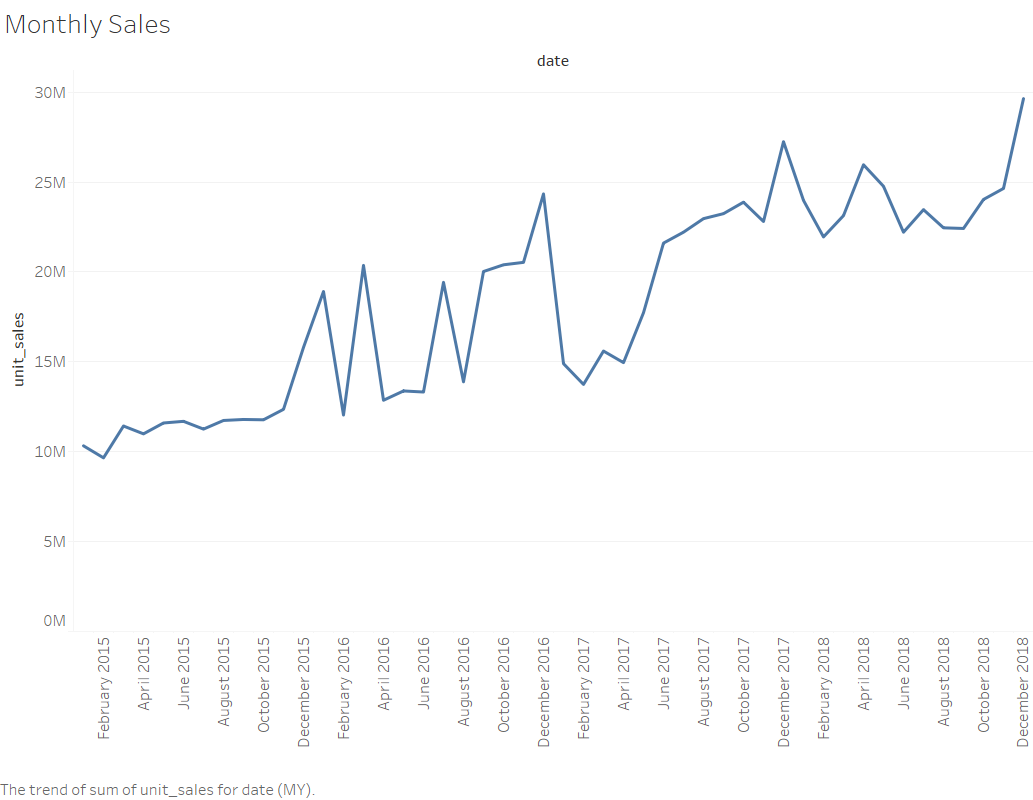

In [4]:
Image(filename='/content/drive/My Drive/PHD/Plots/MonthlySales.png')

Cluster wise sales of Each Business Unit from 2015-2018

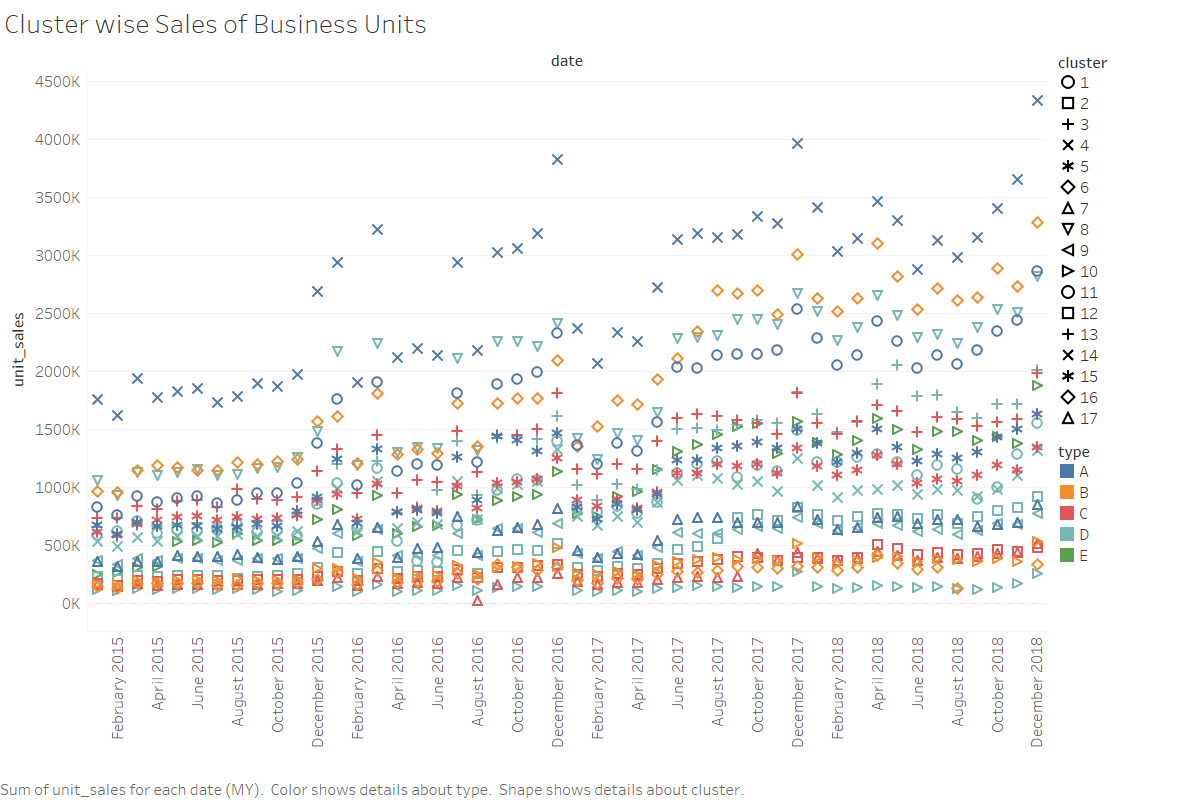

In [5]:
Image(filename='/content/drive/My Drive/PHD/Plots/BCTrain.png')

Sales by each Business Unit

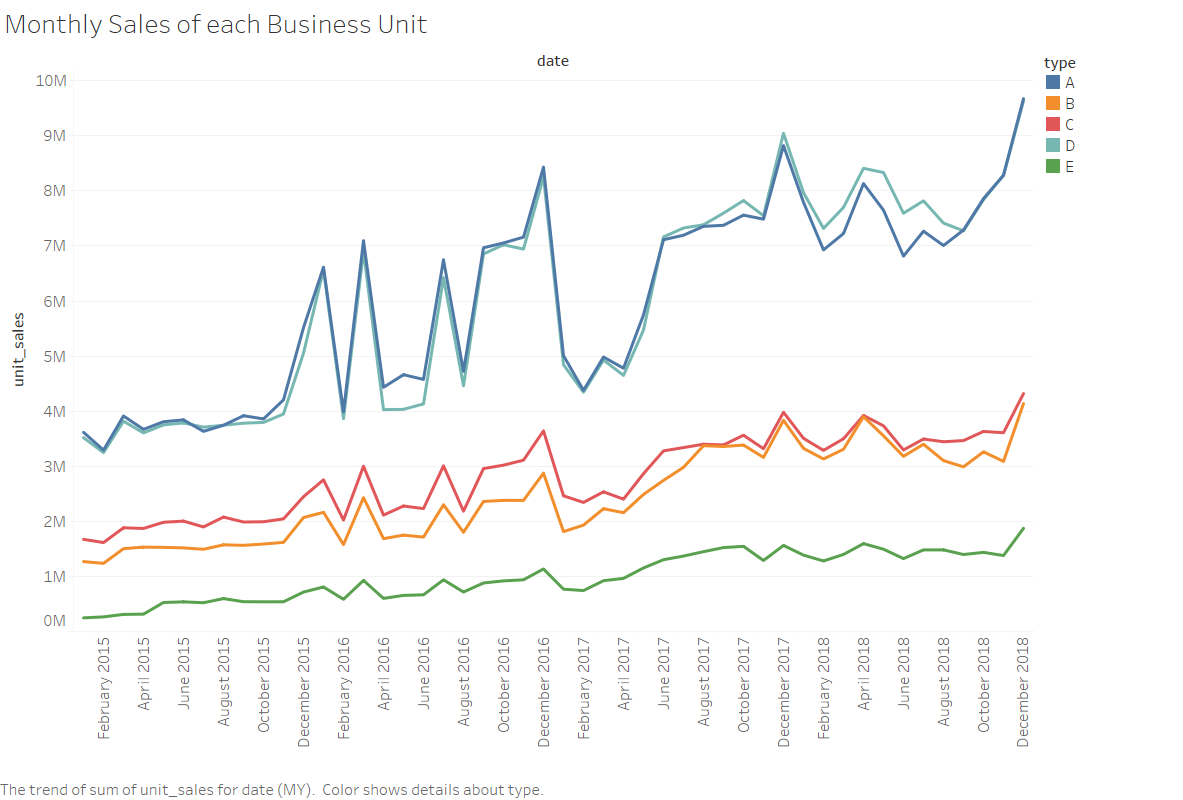

In [11]:
Image('/content/drive/My Drive/PHD/Plots/BUSales.png')

Top 10 selling items between 2015 and 2018

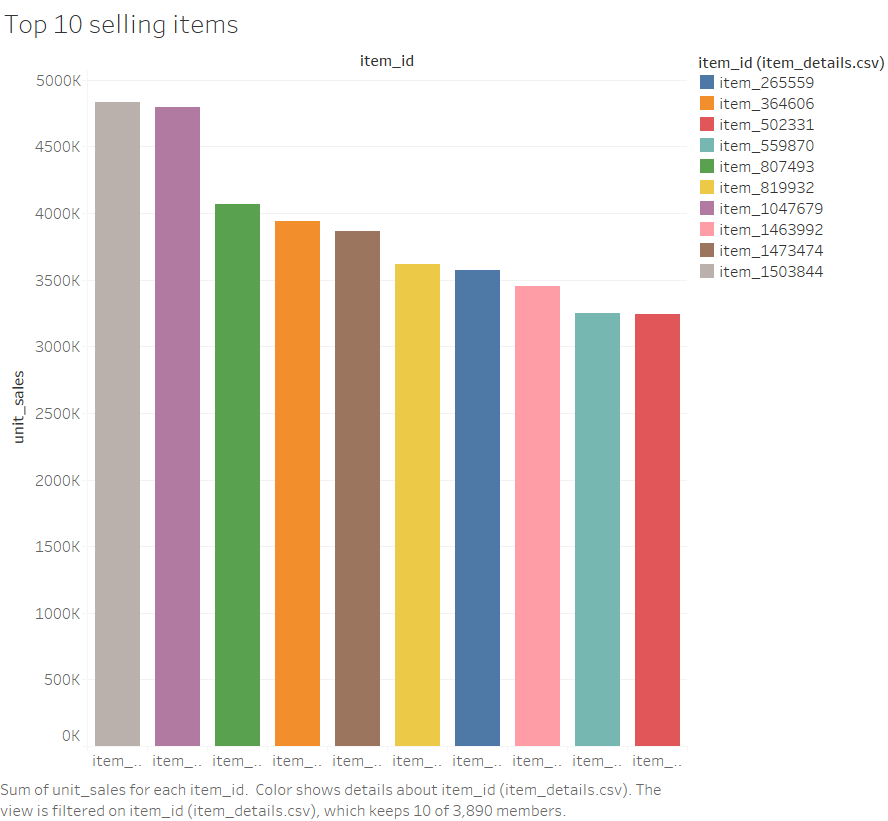

In [10]:
Image('/content/drive/My Drive/PHD/Plots/Top10Train.png')

Location wise Monthly Sales

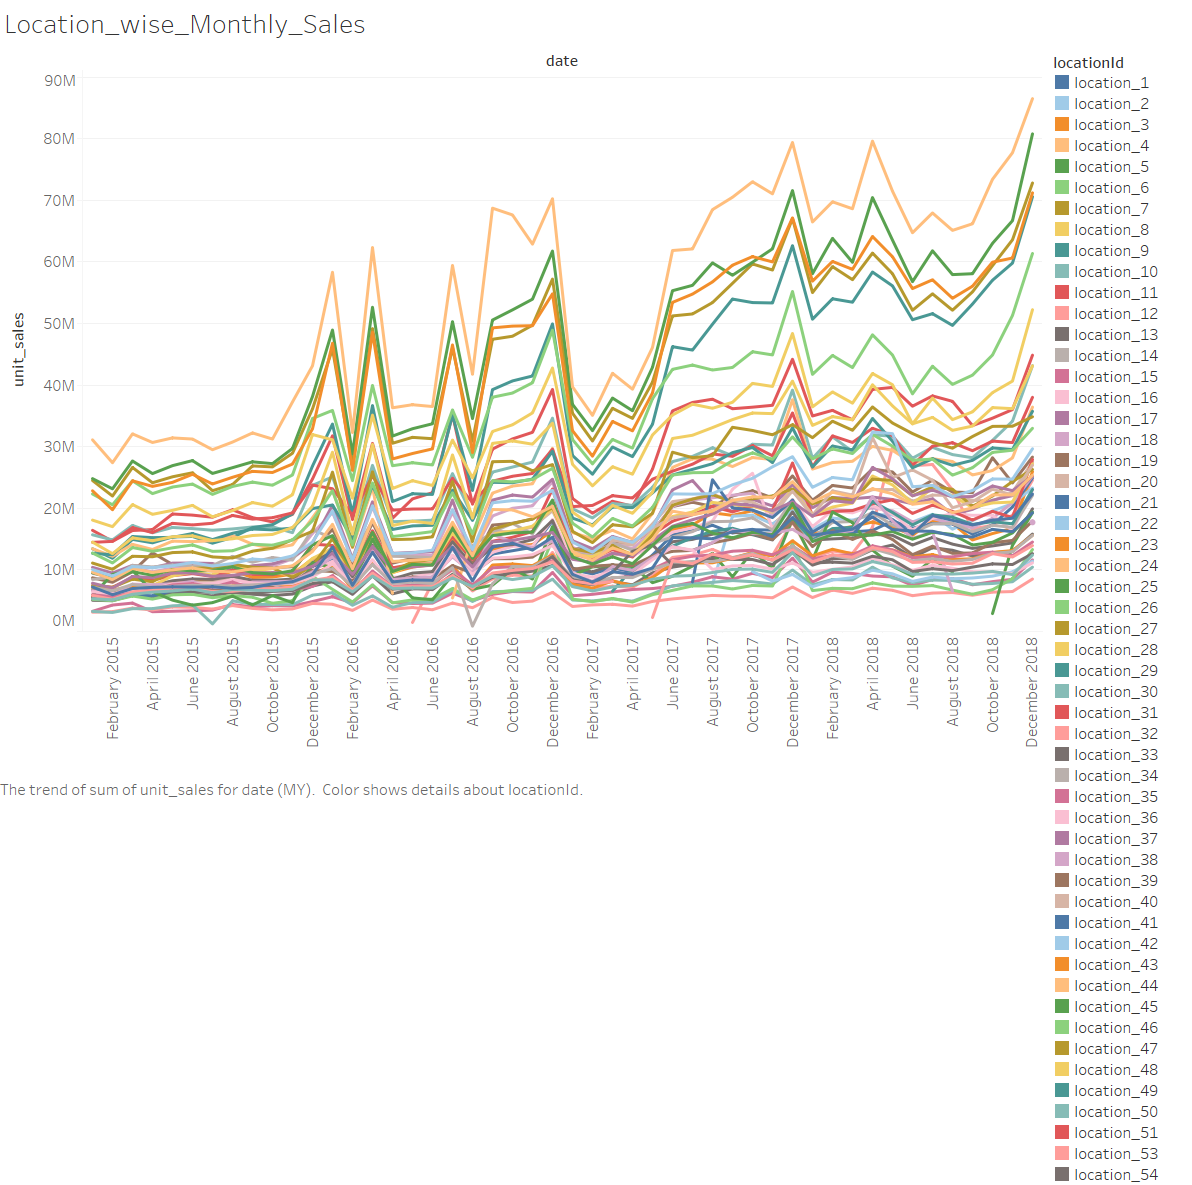

In [0]:
Image('/content/drive/My Drive/PHD/Plots/loc_ms.png')

**EXPLORATORY DATA ANALYSIS**

* **Checking the top and bottom few rows along with the shape**
* **Checking Feature Names**
* **Checking Datatypes of features**
* **Checking Description of the columns**
* **Checking for Null Values**




In [0]:
print(data_train.head())
print("------------------------------------------------------------------------------")
print(data_train.tail())
print("------------------------------------------------------------------------------")
print(data_train.shape)

                date   locationId      item_id  unit_sales onpromotion
38594264  2017-01-01  location_25  item_103665        12.0       False
38594265  2017-01-01  location_25  item_105575        23.0       False
38594266  2017-01-01  location_25  item_108634         1.0       False
38594267  2017-01-01  location_25  item_108698         6.0       False
38594268  2017-01-01  location_25  item_108786         6.0       False
------------------------------------------------------------------------------
                 date   locationId       item_id  unit_sales onpromotion
101688774  2018-12-31  location_54  item_2048381         6.0        True
101688775  2018-12-31  location_54  item_2048421         4.0       False
101688776  2018-12-31  location_54  item_2048471        10.0       False
101688777  2018-12-31  location_54  item_2048515         3.0       False
101688778  2018-12-31  location_54  item_2048674         1.0       False
---------------------------------------------------------

In [0]:
print(data_test.head())
print("-------------------------------------------------------------------------------")
print(data_test.tail())
print("-------------------------------------------------------------------------------")
print(data_test.shape)

   id        date locationId item_id  onpromotion
0   0  2019-01-01         25   99197        False
1   1  2019-01-01         25  103665        False
2   2  2019-01-01         25  105574        False
3   3  2019-01-01         25  105857        False
4   4  2019-01-01         25  106716        False
-------------------------------------------------------------------------------
              id        date locationId  item_id  onpromotion
1482290  1482290  2019-01-15         54  2048381        False
1482291  1482291  2019-01-15         54  2048421        False
1482292  1482292  2019-01-15         54  2048471        False
1482293  1482293  2019-01-15         54  2048515        False
1482294  1482294  2019-01-15         54  2048674        False
-------------------------------------------------------------------------------
(1482295, 5)


In [0]:
data_test.columns

Index(['id', 'date', 'locationId', 'item_id', 'onpromotion'], dtype='object')

In [0]:

data_train.columns

Index(['date', 'locationId', 'item_id', 'unit_sales', 'onpromotion'], dtype='object')

In [0]:
data_train.dtypes

date            object
locationId      object
item_id         object
unit_sales     float64
onpromotion     object
dtype: object

In [0]:
data_test.dtypes

id              int64
date           object
locationId     object
item_id        object
onpromotion      bool
dtype: object

In [0]:
data_train.head(5)

,date,locationId,item_id,unit_sales,onpromotion
38594264,2017-01-01,location_25,item_103665,12.0,False
38594265,2017-01-01,location_25,item_105575,23.0,False
38594266,2017-01-01,location_25,item_108634,1.0,False
38594267,2017-01-01,location_25,item_108698,6.0,False
38594268,2017-01-01,location_25,item_108786,6.0,False


In [0]:
data_test.head(5)

,id,date,locationId,item_id,onpromotion
0,0,2019-01-01,25,99197,False
1,1,2019-01-01,25,103665,False
2,2,2019-01-01,25,105574,False
3,3,2019-01-01,25,105857,False
4,4,2019-01-01,25,106716,False


In [0]:
data_train.describe(include='all')

,date,locationId,item_id,unit_sales,onpromotion
count,63090650,63090650,63090650,6.309065e+07,63090650
unique,728,53,3887,NaN,2
top,2018-02-28,location_44,item_314384,NaN,False
freq,193420,1729698,37415,NaN,58488795
mean,NaN,NaN,NaN,8.394164e+00,NaN
std,NaN,NaN,NaN,2.513940e+01,NaN
min,NaN,NaN,NaN,1.000000e-03,NaN
25%,NaN,NaN,NaN,2.000000e+00,NaN
50%,NaN,NaN,NaN,4.000000e+00,NaN
75%,NaN,NaN,NaN,9.000000e+00,NaN


In [0]:
data_test.describe(include='all')

,id,date,locationId,item_id,onpromotion
count,1.482295e+06,1482295,1482295,1482295,1482295
unique,NaN,15,53,3828,2
top,NaN,2019-01-02,44,222879,False
freq,NaN,114225,40028,742,1301444
mean,7.411470e+05,NaN,NaN,NaN,NaN
std,4.279019e+05,NaN,NaN,NaN,NaN
min,0.000000e+00,NaN,NaN,NaN,NaN
25%,3.705735e+05,NaN,NaN,NaN,NaN
50%,7.411470e+05,NaN,NaN,NaN,NaN
75%,1.111720e+06,NaN,NaN,NaN,NaN


**Checking for Null values in Train and Test data**

In [0]:
data_train.isnull().sum()

date           0
locationId     0
item_id        0
unit_sales     0
onpromotion    0
dtype: int64

In [0]:
data_test.isna().sum()

id             0
date           0
locationId     0
item_id        0
onpromotion    0
dtype: int64

**Drawing a trend towards Location**

In [0]:
data_train.groupby(['locationId']).count()

,date,locationId,item_id,unit_sales
onpromotion,,,,
False,58488795,58488795,58488795,58488795
True,4601855,4601855,4601855,4601855


**FEATURE ENGINEERING**

* **Typecasting the datatypes of certain columns**
* **Converting Date column to numeric datatype**
* **Replacing substring in item and location columns**
* **Separating "id" column from test dataset**

**TypeCasting categorical column datatypes for Train and Test**

In [0]:
for i in data_train.select_dtypes(['object']):
  data_train[i]=data_train[i].astype('category')

In [0]:
for i in data_test.select_dtypes(['bool','object']):
  data_test[i]=data_test[i].astype('category')

In [0]:
data_train.dtypes

date           category
locationId     category
item_id        category
unit_sales      float64
onpromotion    category
dtype: object

In [0]:
data_train['unit_sales']=data_train['unit_sales'].astype('float32')

**Converting Date column to numeric datatype**

In [0]:
data_train['date'] = data_train['date'].astype('datetime64[ns]').dt.normalize()
data_test['date'] = data_test['date'].astype('datetime64[ns]').dt.normalize()

In [0]:
data_train['date']=data_train['date'].map(datetime.datetime.toordinal)

In [0]:
data_test['date']=data_test['date'].map(datetime.datetime.toordinal)

**Replacing substring in item and location column**

In [0]:
data_train['item_id'] = data_train['item_id'].str.replace('item_','')
data_train['locationId'] = data_train['locationId'].str.replace('location_','')

In [0]:
data_test['item_id'] = data_test['item_id'].str.replace('item_','')
data_test['locationId'] = data_test['locationId'].str.replace('location_','')

In [0]:
data_train.head()

,date,locationId,item_id,unit_sales,onpromotion
38594264,736330,25,103665,12.0,False
38594265,736330,25,105575,23.0,False
38594266,736330,25,108634,1.0,False
38594267,736330,25,108698,6.0,False
38594268,736330,25,108786,6.0,False


In [0]:
data_train.dtypes

date              int64
locationId       object
item_id          object
unit_sales      float32
onpromotion    category
dtype: object

In [0]:
data_test.dtypes

id                int64
date              int64
locationId     category
item_id        category
onpromotion    category
dtype: object

**Separating id from test file**

In [0]:
test_id = data_test['id']
data_test.drop('id',axis=1,inplace=True)

In [0]:
data_test.columns

Index(['date', 'locationId', 'item_id', 'onpromotion'], dtype='object')

In [0]:
type(test_id)

pandas.core.series.Series

In [0]:
test_id = test_id.ravel()
print(test_id)

[      0       1       2 ... 1482292 1482293 1482294]


In [0]:
type(test_id)

numpy.ndarray

**Splitting The Data into Train and Validation**

In [0]:
y=data_train["unit_sales"]
X=data_train.drop('unit_sales', axis=1)

In [0]:
cat_attr = list(X.select_dtypes("category").columns)
num_attr = list(X.columns.difference(cat_attr))


In [0]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])



categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_attr),
        ('cat', categorical_transformer, cat_attr)])

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30) 


**MODEL BUILDING**

**Linear Regression**

In [0]:
lin_reg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', LinearRegression())])

In [0]:
lin_reg.fit(X_train,y_train)

In [0]:
train_pred =lin_reg.predict(X_train)
val_pred = lin_reg.predict(X_val)

In [0]:
test_pred = lin_reg.predict(data_test)

**MAPE**

Defining the Mean Absolute Percentage Error function

In [0]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Calculalting the MAPE

In [0]:
mean_absolute_percentage_error(y_val,val_pred)

R square 

In [0]:
r2 = r2_score(y_val,val_pred)

In [0]:
r2

**Plotting the residuals**

In [0]:
sns.residplot(y_val-val_pred,val_pred)

**Saving the predictions to a CSV file**

In [0]:
lin= {"id":test_id,"unit_sales":test_pred}
pd.DataFrame(lin).to_csv("/content/drive/My Drive/PHD/Result/LinearRegression.csv",index=False)

**Elastic Nets**

In [0]:
en_reg=Pipeline(steps=[('preprocessor',preprocessor),('Elastic Nets',ElasticNet(alpha=0.5,l1_ratio=0.5))])

In [0]:
en_reg.fit(X_train,y_train)

In [0]:
train_pred_en=en_reg.predict(X_train)
val_pred_en = en_reg.predict(X_val)
test_pred_en = en_reg.predict(data_test)

**MAPE**

In [0]:
mean_absolute_percentage_error(y_val,val_pred_en)

**Saving the predictions into a CSV file**

In [0]:
en = {"id":test_id,"unit_sales":test_pred_en}
pd.DataFrame(en).to_csv("/content/drive/My Drive/PHD/Result/ElasticNetRegression.csv",index=False)

**XG Boost**

Since Pipeline is not used here, we standardise and dummify the data independently

In [0]:
encode=OneHotEncoder()
encode.fit(X_train)
X_train=encode.transform(X_train)
X_val=encode.transform(X_val)

In [0]:
scaler = StandardScaler(with_mean=False)
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

Transforming the data by applying log on the target column

In [0]:
y_train = np.log1p(y_train)
y_val = np.log1p(y_val)

In [0]:
dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_val, y_val)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Defining a function to calculate the MAPE by converting validation set and predictions to exponential form

In [0]:
def mape_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "mape", mean_absolute_percentage_error(y,yhat)

Running the Model

In [0]:
params = {"objective": "reg:linear", 
          "booster" : "gbtree",     
          "eta": 0.1,              #learning rate to reduce overfitting issues
          "max_depth": 10,          #tree depth
          "subsample": 0.9,         #subsample the data prior to growing trees - overcomes overfitting
          "colsample_bytree": 0.7,  #subsampling of columns for each tree
          "silent": 1,              #verbosity
          "seed": 10                
          }
num_boost_round = 10           #countinue for 10 iterations

print("Training the XGBoost model")

gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, 
      early_stopping_rounds=100,feval=mape_xg,verbose_eval=True)

print("validating")
yhat = gbm.predict(xgb.DMatrix(X_val))
error = mean_absolute_percentage_error(y_val,yhat)

print('MAPE: {:.6f}'.format(error))

Train a XGBoost model
[0]	train-rmse:1.41385	eval-rmse:1.4141	train-mape:67.484	eval-mape:67.4965
Multiple eval metrics have been passed: 'eval-mape' will be used for early stopping.

Will train until eval-mape hasn't improved in 100 rounds.
[1]	train-rmse:1.32461	eval-rmse:1.32486	train-mape:62.2175	eval-mape:62.2317
[2]	train-rmse:1.2477	eval-rmse:1.24793	train-mape:62.3847	eval-mape:62.3998
[3]	train-rmse:1.1822	eval-rmse:1.18243	train-mape:62.6525	eval-mape:62.669
[4]	train-rmse:1.12601	eval-rmse:1.12622	train-mape:63.0359	eval-mape:63.0538
[5]	train-rmse:1.07817	eval-rmse:1.07839	train-mape:63.8696	eval-mape:63.8889
[6]	train-rmse:1.03734	eval-rmse:1.03755	train-mape:64.8305	eval-mape:64.8518
[7]	train-rmse:1.00242	eval-rmse:1.00261	train-mape:67.6283	eval-mape:67.6494
[8]	train-rmse:0.9734	eval-rmse:0.97359	train-mape:70.4842	eval-mape:70.5051
[9]	train-rmse:0.949177	eval-rmse:0.949352	train-mape:73.3784	eval-mape:73.3985
Training time is 308.316435 s.
validating
MAPE: 42.268932


Standardising and dummifying test dataset

In [0]:
cat_test = list(data_test.select_dtypes("category").columns)
num_test = list(data_test.columns.difference(cat_test))

# Standardising the Test Data
scaler = StandardScaler()
scaler.fit(data_test[num_test])

data_test[num_test]=scaler.transform(data_test[num_test])

#Dummifying the categoical columns
encode.fit(data_test[cat_test])
data_test[cat_test] = encode.transform(data_test[cat_test])

**Predicting on Test Data**

In [0]:
test_pred_xg = gbm.predict(data_test)

**Saving predictions to a CSV file**

In [0]:
dt = {"id":test_id,"unit_sales":test_pred_xg}
pd.DataFrame([X,y]).to_csv("/content/drive/My Drive/PHD/Result/XGBBoost.csv",index=False)

## Conclusion

XGBoost gave the best MAPE amongst the three models in predicting the unit sales.

**-----------------------------------------------------------------------------------------------------------------------------------------------------------------** 

**Questions asked by Operations team**


● Business units belonging to which cluster will see the highest amount of
sales for the first 15 days of 2019?  
● What are the top 10 selling items in this cluster?  
● What is the rate of purchase per week for these items?

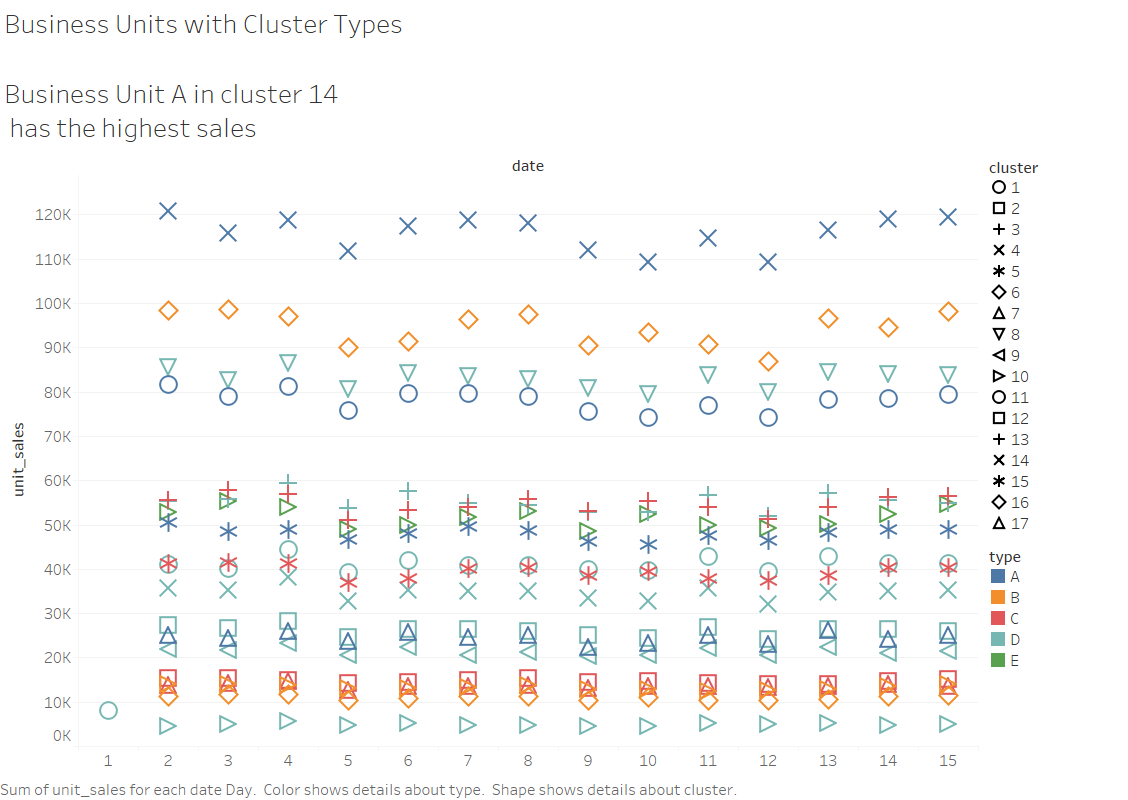

In [12]:
Image('/content/drive/My Drive/PHD/Plots/Business-Cluster sales.png')

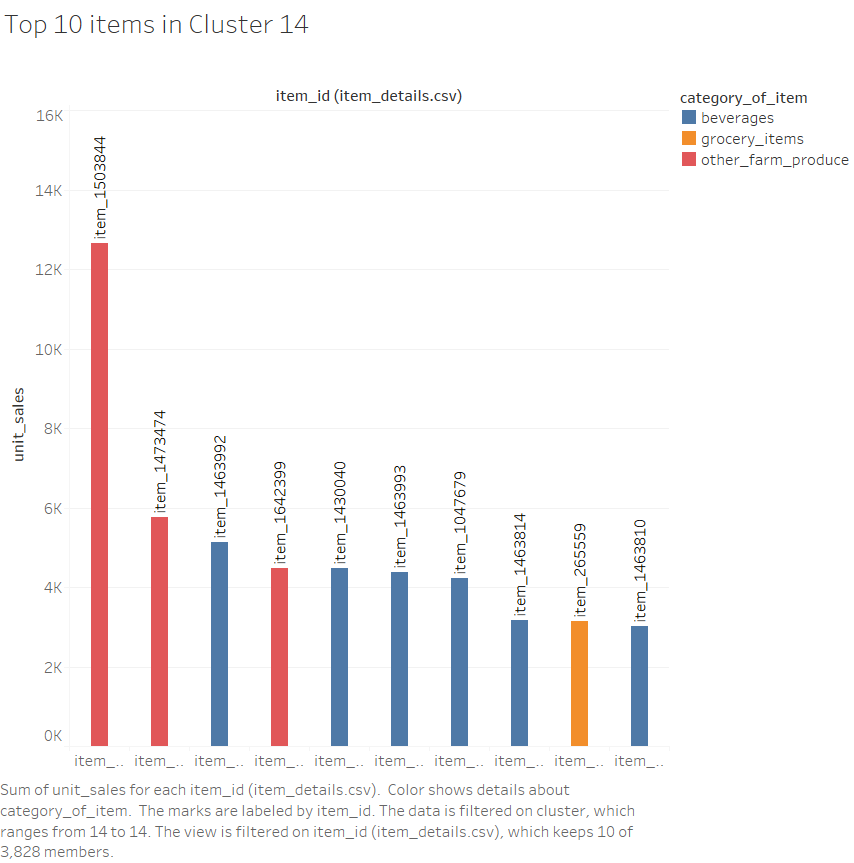

In [14]:
Image('/content/drive/My Drive/PHD/Plots/Top10.png')

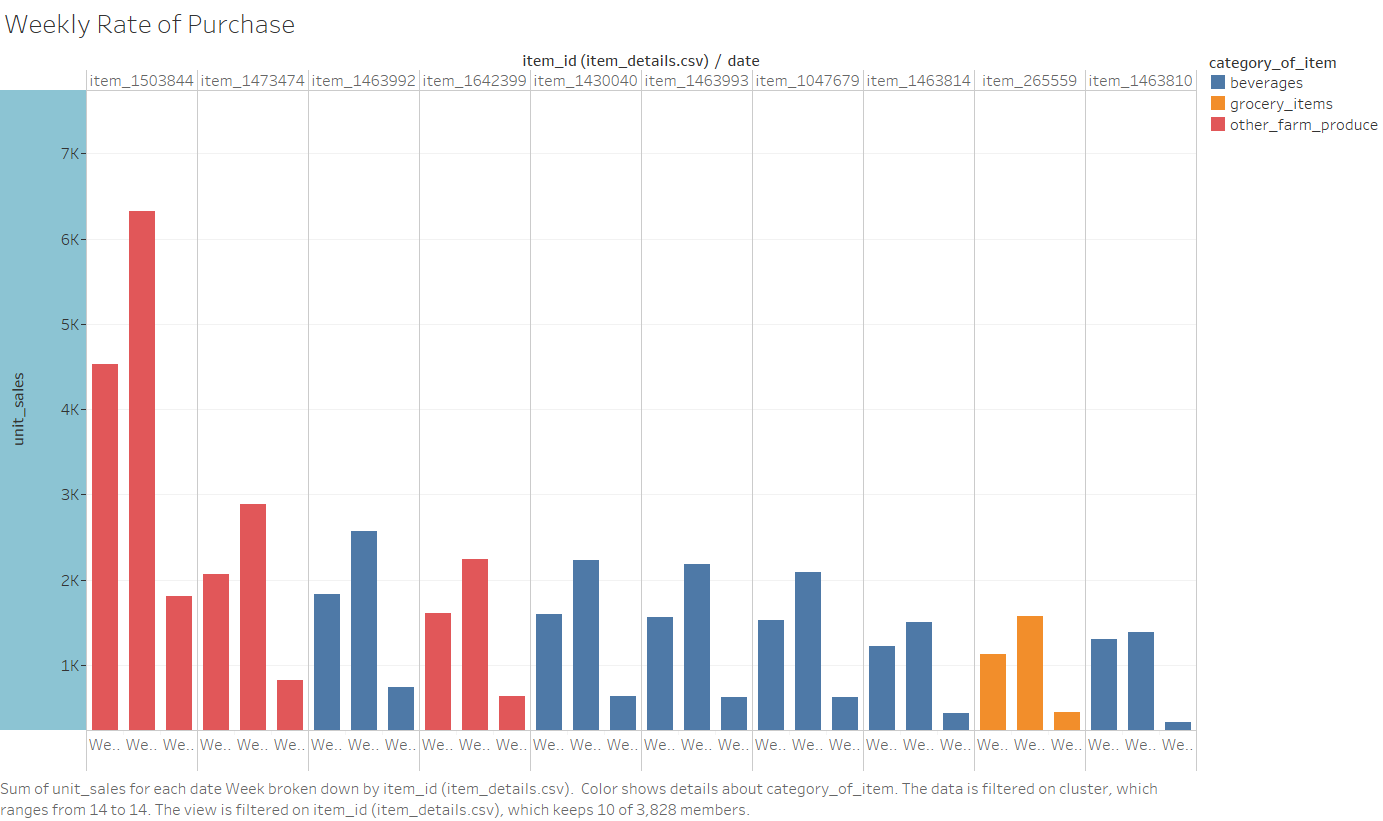

In [18]:
Image('/content/drive/My Drive/PHD/Plots/Rate.png')